In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import yt
import numpy as np
import os
from astropy import units as u
import cv2 as cv

# Reading data and define volume box

In [12]:
# # read the lowest boundary mask and the highest boundary mask
# timestamp = 200
# lowest_z = 0
# highest_z = 600


# lowest_file = f'/home/joy0921/Desktop/2023S/Dataset/200_210/mask_outputs/{timestamp}/sn34_smd132_bx5_pe300_hdf5_plt_cnt_0{timestamp}_z{lowest_z}/metadata.csv'
# highest_file = f'/home/joy0921/Desktop/2023S/Dataset/200_210/mask_outputs/{timestamp}/sn34_smd132_bx5_pe300_hdf5_plt_cnt_0{timestamp}_z{highest_z}/metadata.csv'


# # define the volums cube (read the coordinate)
# low_x0, low_y0, low_w, low_h = 386,456, 350, 343
# # high: 502 646 216 153


In [4]:
# CV lab
datadir = "/home/joy0921/Desktop/Dataset/200_360/finer_time_200_360_original"

# Compute2
# datadir = '/home/joy0921/Desktop/Dataset/200_210/raw_data'

filename = "sn34_smd132_bx5_pe300_hdf5_plt_cnt_0201"

ds = yt.load(os.path.join(datadir, filename))

yt : [INFO     ] 2024-01-11 12:39:23,213 Parameters: current_time              = 6030671655459382.0
yt : [INFO     ] 2024-01-11 12:39:23,213 Parameters: domain_dimensions         = [  32   32 1280]
yt : [INFO     ] 2024-01-11 12:39:23,214 Parameters: domain_left_edge          = [-1.54283879e+21 -1.54283879e+21 -6.17135516e+22]
yt : [INFO     ] 2024-01-11 12:39:23,216 Parameters: domain_right_edge         = [1.54283879e+21 1.54283879e+21 6.17135516e+22]
yt : [INFO     ] 2024-01-11 12:39:23,217 Parameters: cosmological_simulation   = 0


In [5]:
ad = ds.all_data()

center =  [0, 0, 0]*yt.units.pc
arb_center = ds.arr(center,'code_length')
left_edge = arb_center - ds.quan(500,'pc')
right_edge = arb_center + ds.quan(500,'pc')

obj = ds.arbitrary_grid(left_edge, right_edge, dims=[1000,1000,1000])
print(obj["flash", "dens"].shape)

(1000, 1000, 1000)


# Import the log file into panda dataframes

In [1]:
import pandas as pd
from glob import glob
import os

# List all .dat files in the current directory
# CV lab
# dat_file_root = "/home/joy0921/Desktop/2023S/Dataset/SNfeedback"

# Compute2.idsl
dat_file_root = "/home/joy0921/Desktop/Dataset/SNfeedback"

# Mac
# dat_file_root = "/Users/joycelynchen/Desktop/UBC/Research/Program/AstroSegTrack/Data/SNfeedback"

# dat_files = glob(os.path.join(dat_file_root, "*.dat"))
dat_files = ["/home/joy0921/Desktop/Dataset/SNfeedback/SNfeedback.dat"]


# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Read and concatenate data from all .dat files
for dat_file in dat_files:
    # Assuming space-separated values in the .dat files
    df = pd.read_csv(dat_file, delim_whitespace=True, header=None,
                     names=['n_SN', 'type', 'n_timestep', 'n_tracer', 'time',
                            'posx', 'posy', 'posz', 'radius', 'mass'])
    
    # Convert the columns to numerical
    df = df.iloc[1:]
    df['n_SN'] = df['n_SN'].map(int)
    df['type'] = df['type'].map(int)
    df['n_timestep'] = df['n_timestep'].map(int)
    df['n_tracer'] = df['n_tracer'].map(int)
    df['time'] = pd.to_numeric(df['time'],errors='coerce')
    df['posx'] = pd.to_numeric(df['posx'],errors='coerce')
    df['posy'] = pd.to_numeric(df['posy'],errors='coerce')
    df['posz'] = pd.to_numeric(df['posz'],errors='coerce')
    df['radius'] = pd.to_numeric(df['radius'],errors='coerce')
    df['mass'] = pd.to_numeric(df['mass'],errors='coerce')
    all_data = pd.concat([all_data, df], ignore_index=True)
    all_data = all_data.drop(df[df['n_tracer'] != 0].index)

all_data.head()


,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass
0,1,2,12,0,2.869811e+12,9.763277e+20,1.530785e+21,-1.072755e+21,1.243486e+20,4.098446e+35
1,2,1,20,0,4.796885e+12,-1.145076e+21,-1.434358e+21,-1.205343e+19,3.511398e+19,9.042147e+35
2,3,2,26,0,5.738623e+12,3.977631e+20,-1.337930e+21,4.700837e+20,4.278450e+19,4.298436e+35
3,4,2,34,0,8.607434e+12,-1.120969e+21,1.482572e+21,-1.084808e+20,3.511398e+19,8.470546e+35
4,5,1,40,0,9.592771e+12,1.434358e+21,-8.557934e+20,2.205777e+21,3.085678e+20,4.513983e+33


In [2]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12250 entries, 0 to 14124
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   n_SN        12250 non-null  int64  
 1   type        12250 non-null  int64  
 2   n_timestep  12250 non-null  int64  
 3   n_tracer    12250 non-null  int64  
 4   time        12250 non-null  float64
 5   posx        12250 non-null  float64
 6   posy        12250 non-null  float64
 7   posz        12250 non-null  float64
 8   radius      12250 non-null  float64
 9   mass        12250 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.0 MB


In [3]:
# convert seconds to Megayears
def seconds_to_megayears(seconds):
    return seconds / (1e6 * 365 * 24 * 3600)

# Convert pixel value to pc
def pixel2pc(pixel):
    return (pixel * 10) / 8

def cm2pc(cm):
    return cm * 3.24077929e-19

# filter the DataFrame
def filter_data(df, range_coord):
    return df[(df['posx_pc'] > range_coord[0]) & (df['posx_pc'] < range_coord[0] + range_coord[2]) & (df['posy_pc'] > range_coord[1]) & (df['posy_pc'] < range_coord[1] + range_coord[3]) & (df['posz_pc'] > range_coord[4]) & (df['posz_pc'] < range_coord[5])]

def pc2pixel(pc):
    return (pc * 8) / 10

In [4]:
# Convert time to Megayears
all_data['time_Myr'] = seconds_to_megayears(all_data['time'])

# Convert 'pos' from centimeters to parsecs
all_data['posx_pc'] = cm2pc(all_data['posx'])
all_data['posy_pc'] = cm2pc(all_data['posy'])
all_data['posz_pc'] = cm2pc(all_data['posz'])

# Sort the DataFrame by time in ascending order
all_data.sort_values(by='time_Myr', inplace=True)

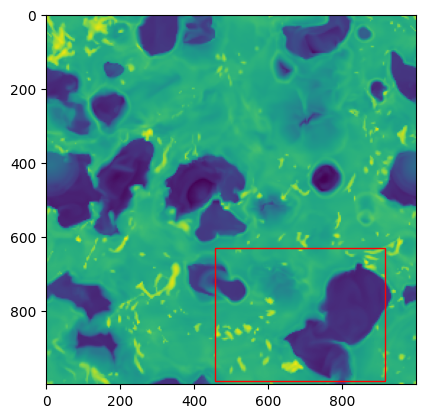

In [7]:
# convert the cube range to pc
low_x0, low_y0, low_w, low_h, bottom_z, top_z = 456,630, 460, 360, -400, 400


# Visualize the selected region on image
# plt.imshow(np.log10(obj["flash", "dens"][:,:,300].T[::-1]))
# plt.colorbar()

# Create figure and axes 
fig, ax = plt.subplots(1) 
  
# Display the image 
ax.imshow(np.log10(obj["flash", "dens"][:,:,500].T[::-1])) 
  
# Create a Rectangle patch 
rect = patches.Rectangle((low_x0, low_y0), low_w, low_h, linewidth=1, 
                         edgecolor='r', facecolor="none")
  
# Add the patch to the Axes 
ax.add_patch(rect) 
plt.show() 

# plt.savefig("density.png")



# low_x0, low_y0, low_w, low_h = pixel2pc(low_x0) - 500, pixel2pc(low_y0) - 500, pixel2pc(low_w), pixel2pc(low_h)
low_x0, low_y0 = low_x0 - 500, low_y0 - 500

In [5]:
low_x0, low_y0, low_w, low_h, bottom_z, top_z = -500, -500, 1000, 1000, -500, 500

In [6]:
start_yr = 199
end_yr = 200

# Filter data based on specified conditions
filtered_data = filter_data(all_data[(all_data['time_Myr'] >= start_yr) & (all_data['time_Myr'] <= end_yr)],
                            (low_x0, low_y0, low_w, low_h, bottom_z, top_z))
# filtered_data = filter_data(all_data[(all_data['time_Myr'] >= start_yr) & (all_data['time_Myr'] <= end_yr)], (-92, -101, 50, 50, -400, 400))


# Print the resulting DataFrame
filtered_data
# filtered_data.iloc[0]["posx_pc"]

,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass,time_Myr,posx_pc,posy_pc,posz_pc
6484,6485,2,50250,0,6.276960e+15,-1.452438e+21,6.448584e+20,-1.386144e+20,6.607856e+19,3.734677e+35,199.041112,-470.703131,208.984375,-44.921874
6485,6486,1,50260,0,6.277815e+15,-1.356011e+21,5.966447e+20,6.810187e+20,5.011083e+19,4.412835e+35,199.068208,-439.453139,193.359375,220.703123
6486,6487,2,50281,0,6.279829e+15,-5.363776e+20,3.796830e+20,-4.520036e+20,5.011083e+19,3.811723e+35,199.132081,-173.828126,123.046874,-146.484374
6487,6488,1,50309,0,6.282611e+15,1.006461e+21,1.392171e+21,-8.377132e+20,5.423182e+19,3.744163e+35,199.220285,326.171861,451.171862,-271.484375
6488,6489,2,50312,0,6.282698e+15,1.295743e+21,1.006461e+21,-1.747747e+20,3.953338e+19,4.068140e+35,199.223050,419.921870,326.171861,-56.640626
6489,6490,3,50316,0,6.282991e+15,-1.356011e+21,1.283690e+21,1.145076e+20,8.713438e+19,6.563060e+35,199.232341,-439.453139,416.015629,37.109376
6490,6491,2,50341,0,6.285567e+15,6.930721e+20,-4.881638e+20,-2.591487e+20,7.151269e+19,4.141821e+35,199.314019,224.609374,-158.203126,-83.984374
6491,6492,3,50360,0,6.287397e+15,3.796830e+20,-4.520036e+20,-4.761104e+20,2.078441e+20,8.255227e+35,199.372045,123.046874,-146.484374,-154.296876
6493,6494,2,50373,0,6.288436e+15,1.464492e+21,-8.015530e+20,1.627213e+20,1.724158e+19,7.784941e+35,199.404988,474.609372,-259.765627,52.734375
6494,6495,2,50404,0,6.291304e+15,4.640570e+20,-4.218700e+19,-4.218700e+19,6.105736e+19,4.460513e+35,199.495957,150.390625,-13.671875,-13.671875


In [65]:
# figuring out the correct z coordinate
obj['flash', 'z'][500,500,130].to('pc')
# -369

zz = obj['flash','z'][500,500,:].to('pc')

filtered_data['posz_pc'].iloc[0]
# 130.859

np.argmin( np.abs(filtered_data['posz_pc'].iloc[0] - zz.value))
# 630

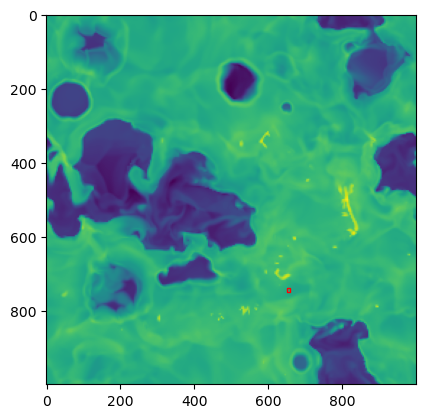

In [78]:
# convert the cube range to pc
low_x0, low_y0, low_w, low_h = 150 + 500, 240 + 500, 10, 10
# low_x0, low_y0, low_w, low_h = 380 + 500, 365 + 500, 10, 10
# low_x0, low_y0, low_w, low_h = pc2pixel(380) + 400, pc2pixel(365) + 400, 10, 10


# Create figure and axes 
fig, ax = plt.subplots()   

# Display the image 
ax.imshow(np.log10(obj["flash", "dens"][:,:,630].T[::-1])) 
  
# Create a Rectangle patch 
rect = patches.Rectangle((low_x0, low_y0), low_w, low_h, linewidth=1, 
                         edgecolor='r', facecolor="none")
  
# Add the patch to the Axes 
ax.add_patch(rect) 
plt.show() 

In [20]:
filtered_data.drop_duplicates(subset=['posx_pc', 'n_tracer', 'n_SN'], keep='last')
filtered_data

,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass,time_Myr,posx_pc,posy_pc,posz_pc
45064,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
90882,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
32617,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
68918,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
89119,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
53030,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
54793,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
8287,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
67155,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
6524,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375


In [77]:
filtered_data.drop(columns=['posx', 'posy', 'posz', 'time'], inplace=True)
filtered_data.to_csv('SNfeedback_185_200.txt', sep='\t', index=False, encoding='utf-8')

In [64]:
z = cm2pc(-6.17135516e+22)
z
x = cm2pc(-1.54283879e+21)
x

-499.999999844066